In [ ]:
import os
import random
import math
import time
from datetime import datetime
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

In [ ]:
# Configuration / Hyperparameters
CFG = {
    "seed": 42,
    "batch_size": 128,
    "epochs": 100,                
    "lr": 0.1,
    "momentum": 0.9,
    "weight_decay": 5e-4,
    "num_workers": 4,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "save_dir": "/kaggle/working/vgg16_cifar10_checkpoints",
    "label_smoothing": 0.1,      
    "cutout_n_holes": 1,
    "cutout_length": 16,
    "mixup_alpha": 0.0,         
    "print_freq": 100
}

os.makedirs(CFG["save_dir"], exist_ok=True)

In [ ]:
# Reproducibility
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # For determinism (might slow down)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(CFG["seed"])

In [ ]:
# Data Augmentation: Cutout
class Cutout:
    """Randomly mask out one or more patches from an image."""
    def __init__(self, n_holes: int, length: int):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        # img is PIL Image converted to Tensor already if used after ToTensor? We'll assume tensor.
        if not isinstance(img, torch.Tensor):
            img = transforms.functional.to_tensor(img)
        h, w = img.shape[1], img.shape[2]
        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask).expand_as(img)
        img = img * mask
        return img

In [ ]:
# Data Preparation / Dataloaders
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
    # Cutout expects tensor input - add as last
    Cutout(n_holes=CFG["cutout_n_holes"], length=CFG["cutout_length"])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
])

def get_dataloaders(batch_size: int, num_workers: int = 4):
    train_set = datasets.CIFAR10(root="/kaggle/working", train=True, download=True, transform=train_transform)
    test_set  = datasets.CIFAR10(root="/kaggle/working", train=False, download=True, transform=test_transform)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_loader, test_loader

In [ ]:
# VGG-16 Model Definition
cfg_vgg16 = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

class VGG(nn.Module):
    def __init__(self, features, num_classes=10, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 1 * 1, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        if init_weights:
            self._initialize_weights()  

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg_list, batch_norm=True):
    layers = []
    in_channels = 3
    for v in cfg_list:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

def vgg16_bn(num_classes=10):
    return VGG(make_layers(cfg_vgg16, batch_norm=True), num_classes=num_classes)


In [ ]:
# Loss Function with Label Smoothing
def get_criterion(label_smoothing=0.0):
    # If label_smoothing==0 uses regular CE
    return nn.CrossEntropyLoss(label_smoothing=label_smoothing)

In [ ]:
# Training and Evaluation Functions
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append((correct_k.mul_(100.0 / batch_size)).item())
        return res

def train_one_epoch(model, loader, criterion, optimizer, device, scaler, epoch):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    n = 0
    pbar = tqdm(enumerate(loader), total=len(loader), desc=f"Train Epoch {epoch+1}", leave=False)
    for i, (images, targets) in pbar:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=(scaler is not None)):
            outputs = model(images)
            loss = criterion(outputs, targets)
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        batch_size = images.size(0)
        acc1 = accuracy(outputs, targets, topk=(1,))[0]

        running_loss += loss.item() * batch_size
        running_acc += acc1 * batch_size
        n += batch_size

        if (i + 1) % CFG["print_freq"] == 0:
            pbar.set_postfix({"loss": f"{running_loss/n:.4f}", "acc1": f"{running_acc/n:.2f}"})

    epoch_loss = running_loss / n
    epoch_acc  = running_acc / n
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device, epoch=None):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    n = 0
    with torch.no_grad():
        pbar = tqdm(enumerate(loader), total=len(loader), desc=f"Eval Epoch {epoch+1}" if epoch is not None else "Eval", leave=False)
        for i, (images, targets) in pbar:
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            outputs = model(images)
            loss = criterion(outputs, targets)

            batch_size = images.size(0)
            acc1 = accuracy(outputs, targets, topk=(1,))[0]

            running_loss += loss.item() * batch_size
            running_acc += acc1 * batch_size
            n += batch_size

    epoch_loss = running_loss / n
    epoch_acc  = running_acc / n
    return epoch_loss, epoch_acc


In [ ]:
# Training Loop
def train_and_evaluate(cfg):
    device = cfg["device"]
    train_loader, test_loader = get_dataloaders(cfg["batch_size"], cfg["num_workers"])

    model = vgg16_bn(num_classes=10).to(device)
    criterion = get_criterion(cfg["label_smoothing"])
    optimizer = optim.SGD(model.parameters(), lr=cfg["lr"], momentum=cfg["momentum"], weight_decay=cfg["weight_decay"], nesterov=False)

    # Cosine annealing
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg["epochs"], eta_min=1e-5)

    # Mixed precision scaler
    scaler = torch.cuda.amp.GradScaler() if device.startswith("cuda") else None

    best_acc = 0.0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lr": []}
    start_time = time.time()

    for epoch in range(cfg["epochs"]):
        # train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, scaler, epoch)
        # validate
        val_loss, val_acc = evaluate(model, test_loader, criterion, device, epoch)
        scheduler.step()

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["lr"].append(optimizer.param_groups[0]["lr"])

        is_best = val_acc > best_acc
        if is_best:
            best_acc = val_acc
            torch.save({
                "epoch": epoch+1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_acc": best_acc,
                "history": history
            }, os.path.join(cfg["save_dir"], "vgg16_cifar10_best.pth"))
        # also save last
        torch.save({
            "epoch": epoch+1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_acc": best_acc,
            "history": history
        }, os.path.join(cfg["save_dir"], "vgg16_cifar10_last.pth"))

        print(f"Epoch [{epoch+1}/{cfg['epochs']}]: train_loss={train_loss:.4f}, train_acc={train_acc:.2f}% | val_loss={val_loss:.4f}, val_acc={val_acc:.2f}% | lr={optimizer.param_groups[0]['lr']:.6f} | best_val_acc={best_acc:.2f}%")

    elapsed = time.time() - start_time
    print(f"Training finished in {elapsed/60:.2f} minutes. Best val acc: {best_acc:.2f}%")
    return model, history, best_acc


In [ ]:
# Visualization
def plot_history(history, save_path=None):
    epochs = len(history["train_loss"])
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, epochs+1), history["train_loss"], label="train_loss")
    plt.plot(range(1, epochs+1), history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(range(1, epochs+1), history["train_acc"], label="train_acc")
    plt.plot(range(1, epochs+1), history["val_acc"], label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()

/tmp/ipykernel_3685/2769703757.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.startswith("cuda") else None
Train Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipykernel_3685/3661233846.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch [1/100]: train_loss=2.0287, train_acc=23.76% | val_loss=1.9376, val_acc=26.75% | lr=0.099975 | best_val_acc=26.75%


Epoch [2/100]: train_loss=1.8360, train_acc=33.79% | val_loss=1.8225, val_acc=34.71% | lr=0.099901 | best_val_acc=34.71%


Epoch [3/100]: train_loss=1.6909, train_acc=43.10% | val_loss=1.5585, val_acc=51.74% | lr=0.099778 | best_val_acc=51.74%


Epoch [4/100]: train_loss=1.5595, train_acc=52.51% | val_loss=1.5314, val_acc=53.60% | lr=0.099606 | best_val_acc=53.60%


Epoch [5/100]: train_loss=1.4545, train_acc=58.51% | val_loss=1.2858, val_acc=65.41% | lr=0.099384 | best_val_acc=65.41%


Epoch [6/100]: train_loss=1.3871, train_acc=62.04% | val_loss=1.3534, val_acc=61.53% | lr=0.099114 | best_val_acc=65.41%


Epoch [7/100]: train_loss=1.3345, train_acc=64.75% | val_loss=1.2579, val_acc=68.90% | lr=0.098796 | best_val_acc=68.90%


Epoch [8/100]: train_loss=1.2941, train_acc=66.82% | val_loss=1.2939, val_acc=67.01% | lr=0.098429 | best_val_acc=68.90%


Epoch [9/100]: train_loss=1.2658, train_acc=68.04% | val_loss=1.3233, val_acc=65.43% | lr=0.098015 | best_val_acc=68.90%


Epoch [10/100]: train_loss=1.2452, train_acc=68.97% | val_loss=1.1582, val_acc=72.26% | lr=0.097553 | best_val_acc=72.26%


Epoch [11/100]: train_loss=1.2170, train_acc=70.61% | val_loss=1.2219, val_acc=71.84% | lr=0.097044 | best_val_acc=72.26%


Epoch [12/100]: train_loss=1.1965, train_acc=71.34% | val_loss=1.1373, val_acc=73.29% | lr=0.096489 | best_val_acc=73.29%


Epoch [13/100]: train_loss=1.1804, train_acc=71.81% | val_loss=1.1184, val_acc=74.17% | lr=0.095888 | best_val_acc=74.17%


Epoch [14/100]: train_loss=1.1683, train_acc=72.45% | val_loss=1.0536, val_acc=76.10% | lr=0.095242 | best_val_acc=76.10%


Epoch [15/100]: train_loss=1.1620, train_acc=72.71% | val_loss=1.2361, val_acc=70.33% | lr=0.094551 | best_val_acc=76.10%


Epoch [16/100]: train_loss=1.1531, train_acc=73.03% | val_loss=1.2116, val_acc=72.63% | lr=0.093816 | best_val_acc=76.10%


Epoch [17/100]: train_loss=1.1469, train_acc=73.50% | val_loss=1.0427, val_acc=78.06% | lr=0.093038 | best_val_acc=78.06%


Epoch [18/100]: train_loss=1.1333, train_acc=73.78% | val_loss=1.1779, val_acc=73.58% | lr=0.092217 | best_val_acc=78.06%


Epoch [19/100]: train_loss=1.1221, train_acc=74.32% | val_loss=1.0206, val_acc=77.82% | lr=0.091355 | best_val_acc=78.06%


Epoch [20/100]: train_loss=1.1133, train_acc=74.80% | val_loss=1.1140, val_acc=75.07% | lr=0.090452 | best_val_acc=78.06%


Epoch [21/100]: train_loss=1.1053, train_acc=75.23% | val_loss=1.1186, val_acc=73.61% | lr=0.089509 | best_val_acc=78.06%


Epoch [22/100]: train_loss=1.0921, train_acc=75.68% | val_loss=0.9885, val_acc=79.59% | lr=0.088527 | best_val_acc=79.59%


Epoch [23/100]: train_loss=1.0898, train_acc=75.89% | val_loss=1.1935, val_acc=71.45% | lr=0.087507 | best_val_acc=79.59%


Epoch [24/100]: train_loss=1.0883, train_acc=75.81% | val_loss=1.0641, val_acc=76.56% | lr=0.086450 | best_val_acc=79.59%


Epoch [25/100]: train_loss=1.0724, train_acc=76.38% | val_loss=1.0513, val_acc=77.32% | lr=0.085357 | best_val_acc=79.59%


Epoch [26/100]: train_loss=1.0681, train_acc=76.45% | val_loss=1.1467, val_acc=73.86% | lr=0.084229 | best_val_acc=79.59%


Epoch [27/100]: train_loss=1.0622, train_acc=76.89% | val_loss=1.2027, val_acc=72.10% | lr=0.083067 | best_val_acc=79.59%


Epoch [28/100]: train_loss=1.0612, train_acc=76.84% | val_loss=1.0464, val_acc=77.02% | lr=0.081873 | best_val_acc=79.59%


Epoch [29/100]: train_loss=1.0453, train_acc=77.54% | val_loss=1.0811, val_acc=76.43% | lr=0.080647 | best_val_acc=79.59%


Epoch [30/100]: train_loss=1.0409, train_acc=77.60% | val_loss=1.2006, val_acc=71.61% | lr=0.079391 | best_val_acc=79.59%


Epoch [31/100]: train_loss=1.0400, train_acc=77.91% | val_loss=0.9490, val_acc=81.32% | lr=0.078106 | best_val_acc=81.32%


Epoch [32/100]: train_loss=1.0311, train_acc=78.15% | val_loss=1.0197, val_acc=78.97% | lr=0.076794 | best_val_acc=81.32%


Epoch [33/100]: train_loss=1.0292, train_acc=78.04% | val_loss=1.0400, val_acc=77.85% | lr=0.075455 | best_val_acc=81.32%


Epoch [34/100]: train_loss=1.0213, train_acc=78.59% | val_loss=1.0057, val_acc=79.18% | lr=0.074090 | best_val_acc=81.32%


Epoch [35/100]: train_loss=1.0105, train_acc=79.02% | val_loss=0.8725, val_acc=83.97% | lr=0.072702 | best_val_acc=83.97%


Epoch [36/100]: train_loss=1.0025, train_acc=79.33% | val_loss=0.9278, val_acc=82.03% | lr=0.071292 | best_val_acc=83.97%


Epoch [37/100]: train_loss=0.9983, train_acc=79.53% | val_loss=0.9089, val_acc=82.94% | lr=0.069860 | best_val_acc=83.97%


Epoch [38/100]: train_loss=0.9978, train_acc=79.44% | val_loss=1.0264, val_acc=77.54% | lr=0.068409 | best_val_acc=83.97%


Epoch [39/100]: train_loss=0.9918, train_acc=79.50% | val_loss=0.9600, val_acc=80.45% | lr=0.066940 | best_val_acc=83.97%


Epoch [40/100]: train_loss=0.9848, train_acc=80.04% | val_loss=0.9318, val_acc=81.64% | lr=0.065454 | best_val_acc=83.97%


Epoch [41/100]: train_loss=0.9747, train_acc=80.39% | val_loss=1.0059, val_acc=79.76% | lr=0.063953 | best_val_acc=83.97%


Epoch [42/100]: train_loss=0.9703, train_acc=80.53% | val_loss=1.0166, val_acc=79.31% | lr=0.062438 | best_val_acc=83.97%


Epoch [43/100]: train_loss=0.9573, train_acc=81.04% | val_loss=1.1756, val_acc=73.50% | lr=0.060911 | best_val_acc=83.97%


Epoch [44/100]: train_loss=0.9584, train_acc=81.06% | val_loss=0.9419, val_acc=82.02% | lr=0.059373 | best_val_acc=83.97%


Epoch [45/100]: train_loss=0.9486, train_acc=81.33% | val_loss=1.0171, val_acc=79.11% | lr=0.057826 | best_val_acc=83.97%


Epoch [46/100]: train_loss=0.9433, train_acc=81.69% | val_loss=1.1028, val_acc=76.22% | lr=0.056271 | best_val_acc=83.97%


Epoch [47/100]: train_loss=0.9424, train_acc=81.70% | val_loss=0.8472, val_acc=85.13% | lr=0.054710 | best_val_acc=85.13%


Epoch [48/100]: train_loss=0.9366, train_acc=81.84% | val_loss=0.8239, val_acc=86.47% | lr=0.053144 | best_val_acc=86.47%


Epoch [49/100]: train_loss=0.9264, train_acc=82.21% | val_loss=0.8525, val_acc=84.98% | lr=0.051575 | best_val_acc=86.47%


Epoch [50/100]: train_loss=0.9206, train_acc=82.58% | val_loss=0.8298, val_acc=86.07% | lr=0.050005 | best_val_acc=86.47%


Epoch [51/100]: train_loss=0.9182, train_acc=82.69% | val_loss=0.8660, val_acc=84.61% | lr=0.048435 | best_val_acc=86.47%


Epoch [52/100]: train_loss=0.9090, train_acc=82.94% | val_loss=0.8955, val_acc=83.51% | lr=0.046866 | best_val_acc=86.47%


Epoch [53/100]: train_loss=0.8974, train_acc=83.51% | val_loss=0.8226, val_acc=86.47% | lr=0.045300 | best_val_acc=86.47%


Epoch [54/100]: train_loss=0.8939, train_acc=83.67% | val_loss=0.8662, val_acc=84.87% | lr=0.043739 | best_val_acc=86.47%


Epoch [55/100]: train_loss=0.8893, train_acc=83.62% | val_loss=0.7973, val_acc=87.15% | lr=0.042184 | best_val_acc=87.15%


Epoch [56/100]: train_loss=0.8804, train_acc=84.17% | val_loss=0.8707, val_acc=84.34% | lr=0.040637 | best_val_acc=87.15%


Epoch [57/100]: train_loss=0.8789, train_acc=84.06% | val_loss=0.8091, val_acc=85.91% | lr=0.039099 | best_val_acc=87.15%


Epoch [58/100]: train_loss=0.8699, train_acc=84.58% | val_loss=0.7918, val_acc=87.58% | lr=0.037572 | best_val_acc=87.58%


Epoch [59/100]: train_loss=0.8587, train_acc=85.21% | val_loss=0.8282, val_acc=85.74% | lr=0.036057 | best_val_acc=87.58%


Epoch [60/100]: train_loss=0.8538, train_acc=85.38% | val_loss=0.8549, val_acc=84.84% | lr=0.034556 | best_val_acc=87.58%


Epoch [61/100]: train_loss=0.8503, train_acc=85.40% | val_loss=0.7782, val_acc=87.98% | lr=0.033070 | best_val_acc=87.98%


Epoch [62/100]: train_loss=0.8403, train_acc=85.94% | val_loss=0.7704, val_acc=88.61% | lr=0.031601 | best_val_acc=88.61%


Epoch [63/100]: train_loss=0.8326, train_acc=86.01% | val_loss=0.7583, val_acc=88.91% | lr=0.030150 | best_val_acc=88.91%


Epoch [64/100]: train_loss=0.8200, train_acc=86.58% | val_loss=0.8481, val_acc=84.80% | lr=0.028718 | best_val_acc=88.91%


Epoch [65/100]: train_loss=0.8169, train_acc=86.76% | val_loss=0.7442, val_acc=89.29% | lr=0.027308 | best_val_acc=89.29%


Epoch [66/100]: train_loss=0.8097, train_acc=87.23% | val_loss=0.7869, val_acc=87.78% | lr=0.025920 | best_val_acc=89.29%


Epoch [67/100]: train_loss=0.8016, train_acc=87.50% | val_loss=0.7688, val_acc=88.74% | lr=0.024555 | best_val_acc=89.29%


Epoch [68/100]: train_loss=0.7889, train_acc=87.88% | val_loss=0.7727, val_acc=88.29% | lr=0.023216 | best_val_acc=89.29%


Epoch [69/100]: train_loss=0.7871, train_acc=88.09% | val_loss=0.7287, val_acc=90.14% | lr=0.021904 | best_val_acc=90.14%


Epoch [70/100]: train_loss=0.7788, train_acc=88.43% | val_loss=0.7198, val_acc=90.47% | lr=0.020619 | best_val_acc=90.47%


Epoch [71/100]: train_loss=0.7688, train_acc=88.87% | val_loss=0.7462, val_acc=89.54% | lr=0.019363 | best_val_acc=90.47%


Epoch [72/100]: train_loss=0.7635, train_acc=89.19% | val_loss=0.7436, val_acc=89.88% | lr=0.018137 | best_val_acc=90.47%


Epoch [73/100]: train_loss=0.7575, train_acc=89.26% | val_loss=0.7177, val_acc=90.42% | lr=0.016943 | best_val_acc=90.47%


Epoch [74/100]: train_loss=0.7437, train_acc=89.90% | val_loss=0.7431, val_acc=89.18% | lr=0.015781 | best_val_acc=90.47%


Epoch [75/100]: train_loss=0.7388, train_acc=90.15% | val_loss=0.7207, val_acc=90.54% | lr=0.014653 | best_val_acc=90.54%


Epoch [76/100]: train_loss=0.7293, train_acc=90.46% | val_loss=0.7026, val_acc=91.38% | lr=0.013560 | best_val_acc=91.38%


Epoch [77/100]: train_loss=0.7198, train_acc=90.87% | val_loss=0.6897, val_acc=92.01% | lr=0.012503 | best_val_acc=92.01%


Epoch [78/100]: train_loss=0.7188, train_acc=90.98% | val_loss=0.7405, val_acc=89.81% | lr=0.011483 | best_val_acc=92.01%


Epoch [79/100]: train_loss=0.7075, train_acc=91.44% | val_loss=0.6831, val_acc=92.11% | lr=0.010501 | best_val_acc=92.11%


Epoch [80/100]: train_loss=0.6934, train_acc=92.05% | val_loss=0.6915, val_acc=91.77% | lr=0.009558 | best_val_acc=92.11%


Epoch [81/100]: train_loss=0.6890, train_acc=92.29% | val_loss=0.6681, val_acc=92.78% | lr=0.008655 | best_val_acc=92.78%


Epoch [82/100]: train_loss=0.6806, train_acc=92.64% | val_loss=0.6652, val_acc=92.92% | lr=0.007793 | best_val_acc=92.92%


Epoch [83/100]: train_loss=0.6723, train_acc=92.98% | val_loss=0.6783, val_acc=92.41% | lr=0.006972 | best_val_acc=92.92%


Epoch [84/100]: train_loss=0.6654, train_acc=93.30% | val_loss=0.6654, val_acc=92.96% | lr=0.006194 | best_val_acc=92.96%


Epoch [85/100]: train_loss=0.6545, train_acc=93.71% | val_loss=0.6599, val_acc=92.92% | lr=0.005459 | best_val_acc=92.96%


Epoch [86/100]: train_loss=0.6493, train_acc=94.04% | val_loss=0.6567, val_acc=93.33% | lr=0.004768 | best_val_acc=93.33%


Epoch [87/100]: train_loss=0.6437, train_acc=94.32% | val_loss=0.6678, val_acc=92.78% | lr=0.004122 | best_val_acc=93.33%


Epoch [88/100]: train_loss=0.6326, train_acc=94.76% | val_loss=0.6502, val_acc=93.75% | lr=0.003521 | best_val_acc=93.75%


Epoch [89/100]: train_loss=0.6292, train_acc=94.85% | val_loss=0.6449, val_acc=93.71% | lr=0.002966 | best_val_acc=93.75%


Epoch [90/100]: train_loss=0.6222, train_acc=95.17% | val_loss=0.6509, val_acc=93.58% | lr=0.002457 | best_val_acc=93.75%


Epoch [91/100]: train_loss=0.6160, train_acc=95.48% | val_loss=0.6455, val_acc=93.92% | lr=0.001995 | best_val_acc=93.92%


Epoch [92/100]: train_loss=0.6120, train_acc=95.66% | val_loss=0.6429, val_acc=93.85% | lr=0.001581 | best_val_acc=93.92%


Epoch [93/100]: train_loss=0.6057, train_acc=95.91% | val_loss=0.6430, val_acc=93.97% | lr=0.001214 | best_val_acc=93.97%


Epoch [94/100]: train_loss=0.6035, train_acc=95.99% | val_loss=0.6390, val_acc=93.92% | lr=0.000896 | best_val_acc=93.97%


Epoch [95/100]: train_loss=0.6001, train_acc=96.18% | val_loss=0.6382, val_acc=94.20% | lr=0.000626 | best_val_acc=94.20%


Epoch [96/100]: train_loss=0.5992, train_acc=96.18% | val_loss=0.6376, val_acc=94.09% | lr=0.000404 | best_val_acc=94.20%


Epoch [97/100]: train_loss=0.5964, train_acc=96.29% | val_loss=0.6376, val_acc=94.17% | lr=0.000232 | best_val_acc=94.20%


Epoch [98/100]: train_loss=0.5942, train_acc=96.37% | val_loss=0.6362, val_acc=94.14% | lr=0.000109 | best_val_acc=94.20%


Epoch [99/100]: train_loss=0.5946, train_acc=96.43% | val_loss=0.6368, val_acc=94.11% | lr=0.000035 | best_val_acc=94.20%


Epoch [100/100]: train_loss=0.5967, train_acc=96.32% | val_loss=0.6370, val_acc=94.10% | lr=0.000010 | best_val_acc=94.20%
Training finished in 25.02 minutes. Best val acc: 94.20%


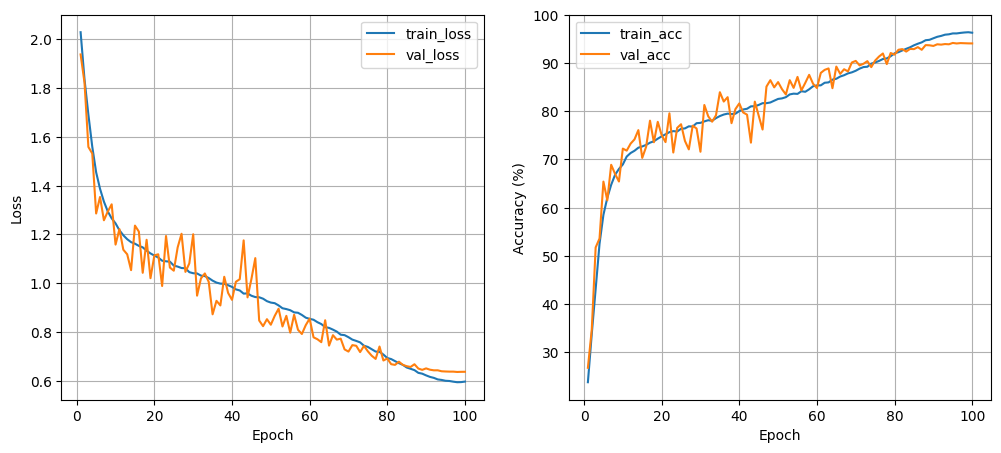

Best validation accuracy: 94.20%


In [ ]:
# Run Training and Evaluation
model, history, best_acc = train_and_evaluate(CFG)
plot_history(history, save_path=os.path.join(CFG["save_dir"], "training_curves.png"))
print("Best validation accuracy: {:.2f}%".format(best_acc))

In [ ]:
# Model Summary
from torchsummary import summary

summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [ ]:
# Save the model
torch.save(model.state_dict(), "VGG_model.pth")

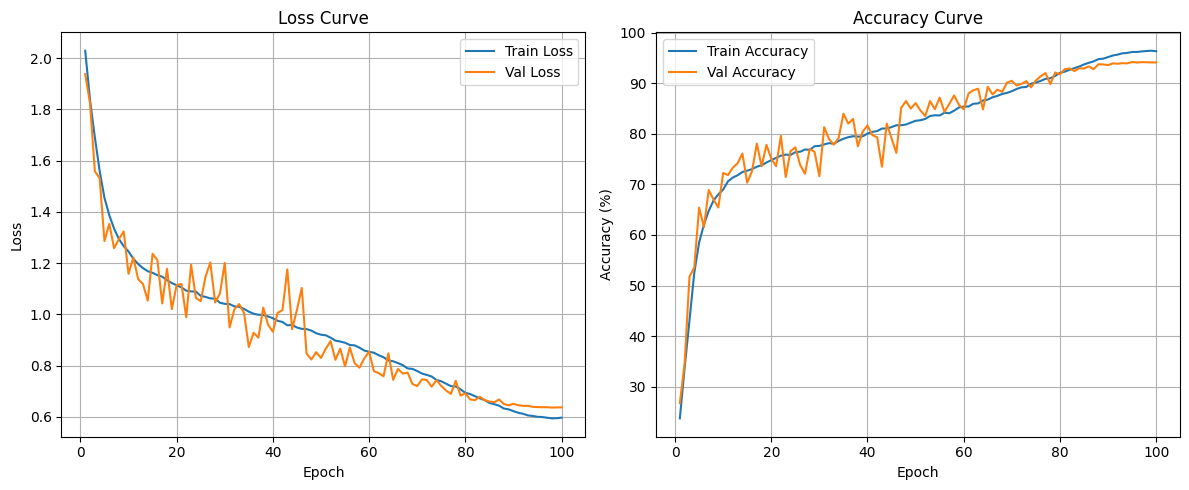

In [ ]:
# Save training curves as a single image
def save_training_curves(history, save_path="training_curves.png"):
    epochs = len(history["train_loss"])
    plt.figure(figsize=(12, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), history["train_loss"], label="Train Loss")
    plt.plot(range(1, epochs + 1), history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid(True)

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), history["train_acc"], label="Train Accuracy")
    plt.plot(range(1, epochs + 1), history["val_acc"], label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Curve")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()

# Call the function
save_training_curves(history, save_path="accuracy_loss_graph.png")